# Reference

* https://github.com/rcmalli/keras-vggface

## install VGGFace
`pip install git+https://github.com/rcmalli/keras-vggface.git`


In [1]:
import os
import numpy as np
from tqdm import tqdm
import pickle
from keras.preprocessing import image
from keras_vggface.vggface import VGGFace
from keras_vggface import utils


from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


# Change the image path with yours.
def process_image(img,model):
    if model == 'vgg16':
        version = 1
    else:
        version = 2
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = utils.preprocess_input(x, version=version) # or version=2
    return x

def extract_features(input, model = 'vgg16', pooling = 'avg', save = True):
    
    vggface = VGGFace(model = model, 
                      include_top=False, 
                      input_shape=(224, 224, 3), 
                      pooling=pooling) # pooling: None, avg or max
    
    face_array = {}
    if os.path.isfile(input):
        img = image.load_img(input, target_size=(224, 224))
        res = vggface.predict(process_image(img, model))[0,:]
        if pooling == None:
            res = res.reshape(-1)
        face_array[input.split('/')[-1]] = res
        
    if os.path.isdir(input):
        for i in tqdm(os.listdir(input)):
            img = image.load_img('%s/%s'%(input,i), target_size=(224, 224))
            res = vggface.predict(process_image(img, model))[0,:]
            if pooling == None:
                res = res.reshape(-1)
            face_array[i] = res

    if not os.path.exists('features'):
        os.mkdir('features')
    
    if save:
        save_object(face_array, './features/face_%s_%s.pkl'%(model, pooling))
        print('saved feature to [./features/face_%s_%s.pkl]'%(model, pooling))

    return face_array

def load_object(filename):
    with open(filename, 'rb') as f:
        res = pickle.load(f)
    return res

def save_object(obj, filename):
    with open(filename, 'wb') as f:
        pickle.dump(obj, f)

Using TensorFlow backend.


In [2]:
POOL = 'max'
face_vgg16 = extract_features('./face', model = 'vgg16', pooling = POOL)
face_resnet50 = extract_features('./face', model = 'resnet50', pooling = POOL)

W0816 00:47:46.353878 140681873377088 deprecation_wrapper.py:119] From /home/chaoran/anaconda3/envs/mypy36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0816 00:47:46.361782 140681873377088 deprecation_wrapper.py:119] From /home/chaoran/anaconda3/envs/mypy36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0816 00:47:46.363151 140681873377088 deprecation_wrapper.py:119] From /home/chaoran/anaconda3/envs/mypy36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0816 00:47:46.378279 140681873377088 deprecation_wrapper.py:119] From /home/chaoran/anaconda3/envs/mypy36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is depre

saved feature to [./features/face_vgg16_max.pkl]


W0816 00:48:02.849167 140681873377088 deprecation_wrapper.py:119] From /home/chaoran/anaconda3/envs/mypy36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3980: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.

100%|██████████| 887/887 [00:15<00:00, 65.12it/s]

saved feature to [./features/face_resnet50_max.pkl]


,nameid,name,book_date,city,holding_location,age,height,weight,race,sex,eyes,hair,bookid,bmi,index,gender
0,531010,TROY MIKEL HOKE,6/30/2019 4:24:07 AM,"DES MOINES, IA",PCJ,28,69,160,White,Male,Brown,Brown,296174,23.625289,296174.jpg,1
1,695392,MARTIN WAYNE LOONEY,7/12/2019 10:59:29 AM,"URBANDALE, IA",PCJ,26,72,175,Black,Male,Brown,Black,296824,23.731674,296824.jpg,1
2,850957,REESE WAYNE WEGENER,7/9/2019 4:59:27 PM,"DES MOINES, IA",WASH-M,30,72,180,White,Male,Blue,Brown,296645,24.409722,296645.jpg,1
3,559407,TALONDA NASHAWN SCALES,6/30/2019 8:17:39 PM,"DES MOINES, IA",PCJ,37,60,168,Black,Female,Brown,Black,296194,32.806667,296194.jpg,0
4,65861,RACHELLE ANGELIC JONES,3/18/2019 12:53:17 PM,"DES MOINES, IA",PCJ,31,68,190,Black,Female,Brown,Black,290118,28.886246,290118.jpg,0


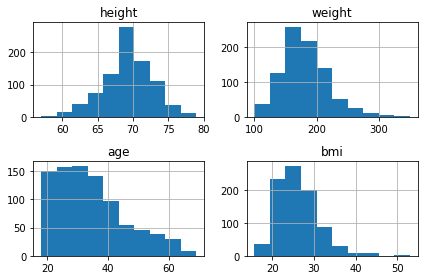

In [3]:
# prepare data
%matplotlib inline
import pandas as pd
import re
def _convert_height(x):
    """ convert string height to inches(int)
    Args:
        @x: str
    Return:
        height in inches (int)
    """
    try:
        x = re.sub('[^0-9]','',x)
        x = int(x[0]) * 12 + int(x[1:])
    except:
        x = None
    return x

data = pd.read_csv('./full.csv')

data['height'] = data.height.map(_convert_height)
data['bmi'] = data.weight / data.height / data.height * 703
data['index'] = data.bookid.map(lambda i: str(i)+'.jpg')
data['gender'] = data.sex.map(lambda i: 1 if i == 'Male' else 0)

# filter unreasonable value
data = data.loc[(data.weight > 0) & (data.height <80),:]

import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=2, ncols=2)
data.height.hist(ax=axes[0,0])
data.weight.hist(ax=axes[0,1])
data.age.hist(ax=axes[1,0])
data.bmi.hist(ax=axes[1,1])
axes[0,0].set_title('height')
axes[0,1].set_title('weight')
axes[1,0].set_title('age')
axes[1,1].set_title('bmi')
plt.tight_layout()

data.to_csv('./full_recoded.csv', index = False)
data.head()

In [4]:
#train model

from sklearn.linear_model import LassoCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics.regression import mean_squared_error, mean_absolute_error
from sklearn.metrics.classification import f1_score
from sklearn.metrics import roc_auc_score
from scipy.stats import pearsonr

def train_model(face_array, label = 'bmi', split_ratio = 0.8, type = 'reg'):
    
    face_array = pd.DataFrame(face_array).T
    data = pd.read_csv('./full_recoded.csv').set_index('index')
    data = data[[label]].join(face_array, how = 'inner')
    
    # split train/valid
    in_train = np.random.uniform(size = len(data)) <= split_ratio

    y = data.iloc[:,0].values
    X = data.iloc[:, 1:].values

    X_train = X[in_train,:]
    y_train = y[in_train]
    X_valid = X[~in_train,:]
    y_valid = y[~in_train]
    
    if type == 'reg':
        lasso_reg = LassoCV(alphas=[0.1,0.3,0.5,0.9], cv=5, max_iter=5000).fit(X_train, y_train)
        y_pred = lasso_reg.predict(X_valid)

        print('rmse: %5.3f'%(np.sqrt(mean_squared_error(y_pred, y_valid))))
        print('mae: %5.3f'%(mean_absolute_error(y_pred, y_valid)))
        print('corr: %5.3f with p-value: %5.3f'%(pearsonr(y_pred, y_valid)))
        
        return lasso_reg
    
    else:
        lr = LogisticRegressionCV(cv = 5, max_iter=1000).fit(X_train, y_train)
        y_pred = lr.predict_proba(X_valid)[:,1]
        print('auc: %5.3f'%(roc_auc_score(y_valid, y_pred)))
        
        return lr

In [5]:
face_array1 = load_object('./features/face_vgg16_%s.pkl'%(POOL))
face_array2 = load_object('./features/face_resnet50_%s.pkl'%(POOL))

In [6]:
print(pd.DataFrame(face_array1).T.shape)
print(pd.DataFrame(face_array2).T.shape)

(887, 512)
(887, 2048)


In [7]:
print('GENDER:')
gender_model = train_model(face_array1, label = 'gender', type = 'clas')
print('BMI:')
bmi_model = train_model(face_array1, label = 'bmi')
print('AGE:')
age_model = train_model(face_array1, label = 'age')
models = (age_model, gender_model, bmi_model)
save_object(models, 'saved_model/models_vgg16_%s.pkl'%(POOL))

GENDER:
auc: 0.997
BMI:
rmse: 4.696
mae: 3.676
corr: 0.334 with p-value: 0.000
AGE:
rmse: 8.804
mae: 7.058
corr: 0.745 with p-value: 0.000


In [8]:
print('GENDER:')
gender_model = train_model(face_array2, label = 'gender', type = 'clas')
print('BMI:')
bmi_model = train_model(face_array2, label = 'bmi')
print('AGE:')
age_model = train_model(face_array2, label = 'age')
models = (age_model, gender_model, bmi_model)
save_object(models, 'saved_model/models_resnet50_%s.pkl'%(POOL))

GENDER:
auc: 0.962
BMI:
rmse: 4.772
mae: 3.705
corr: 0.265 with p-value: 0.001
AGE:
rmse: 9.100
mae: 7.100
corr: 0.649 with p-value: 0.000


In [9]:
# predict
def predict_model(models, input, model, pooling):
    face_test = extract_features(input, model, pooling, save = False)
    face_test = pd.DataFrame(face_test).T
    age_model, gender_model, bmi_model = models
    nameid = face_test.index
    gender = gender_model.predict_proba(face_test)[:,1]
    sex = ['Male' if i > 0.5 else 'Female' for i in gender]
    age = age_model.predict(face_test)
    bmi = bmi_model.predict(face_test)
    res = pd.DataFrame({'nameid':nameid, 
                        'sex_score': np.round(gender,2), 
                        'sex':sex, 
                        'age':np.round(age,0), 
                        'bmi':np.round(bmi,1)})
    return res

In [24]:
POOL = None
models = load_object('./saved_model/models_vgg16_%s.pkl'%(POOL))
predict_model(models, './test/0', 'vgg16', POOL)

100%|██████████| 9/9 [00:00<00:00, 11.82it/s]


,nameid,sex_score,sex,age,bmi
0,barack-obama.jpg,0.97,Male,29.0,20.100000
1,kent_cheng.jpg,0.96,Male,60.0,30.299999
2,clinton-3.jpg,0.00,Female,48.0,28.500000
3,trump.jpg,0.65,Male,79.0,23.600000
4,emma_watson.jpg,0.43,Female,-9.0,18.000000
5,Leonardo_Dicaprio_Cannes_2019.jpg,1.00,Male,42.0,28.900000
6,leonardo1.jpeg,0.40,Female,23.0,17.600000
7,xi.jpg,0.90,Male,69.0,23.400000
8,kent_zheng.jpg,1.00,Male,47.0,38.200001


In [28]:
POOL = 'avg'
models = load_object('./saved_model/models_vgg16_%s.pkl'%(POOL))
predict_model(models, './test/0', 'vgg16', POOL)

100%|██████████| 9/9 [00:00<00:00,  9.73it/s]


,nameid,sex_score,sex,age,bmi
0,barack-obama.jpg,1.00,Male,36.0,25.900000
1,kent_cheng.jpg,1.00,Male,53.0,39.500000
2,clinton-3.jpg,0.00,Female,55.0,26.700001
3,trump.jpg,0.99,Male,71.0,30.200001
4,emma_watson.jpg,1.00,Male,6.0,24.100000
5,Leonardo_Dicaprio_Cannes_2019.jpg,1.00,Male,43.0,33.000000
6,leonardo1.jpeg,1.00,Male,30.0,25.500000
7,xi.jpg,1.00,Male,60.0,32.099998
8,kent_zheng.jpg,1.00,Male,49.0,37.200001
